In [1]:
import os
import mat73
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.style': 'oblique'})
data_path = "/Users/yaoling/OneDrive - NTNU/MASCOT_PhD/Data/Porto/D2_3D_salinity-021.mat"
os.system("say It will take a long time to import data")
sal_data = mat73.loadmat(data_path)
os.system('say Finished Data importing')
print("Everything works fine")

0

In [2]:
# filter out nan values, otherwise later average will have problems
def filterNaN(Delft3D):
    lon = Delft3D['data']["X"]
    lat = Delft3D['data']['Y']
    depth = Delft3D['data']['Z']
    timestamp = (Delft3D['data']['Time'] - 719529) * 24 * 3600
    # salinity = np.mean(Delft3D['data']['Val'], axis = 0)
    Lon = lon[:, :, 0]
    Lat = lat[:, :, 0]
    Depth = depth[0, :, :, 0]
    S = np.mean(Delft3D['data']['Val'][:, :, :, 0], axis=0)

    LAT = []
    LON = []
    SAL = []
    DEPTH = []
    for i in range(Lon.shape[0]):
        for j in range(Lon.shape[1]):
            if np.isnan(Lon[i, j]) or np.isnan(Lat[i, j]) or np.isnan(Depth[i, j]) or np.isnan(S[i, j]):
                pass
            else:
                LAT.append(Lat[i, j])
                LON.append(Lon[i, j])
                DEPTH.append(Depth[i, j])
                SAL.append(S[i, j])
    LAT = np.array(LAT).reshape(-1, 1)
    LON = np.array(LON).reshape(-1, 1)
    DEPTH = np.array(DEPTH).reshape(-1, 1)
    SAL = np.array(SAL).reshape(-1, 1)
    return LAT, LON, DEPTH, SAL, timestamp

lat, lon, depth, sal, timestamp = filterNaN(sal_data)

In [3]:
# Convert lat lon to x y, where x is pointing north, y is pointing east, and depth is z
lat_origin, lon_origin = 41.10251, -8.669811
circumference = 40075000
def deg2rad(deg):
    return deg / 180 * np.pi
def rad2deg(rad):
    return rad / np.pi * 180
def latlon2xy(lat, lon, lat_origin, lon_origin):
    x = deg2rad(lat - lat_origin) / 2 / np.pi * circumference
    y = deg2rad(lon - lon_origin) / 2 / np.pi * circumference * np.cos(deg2rad(lat))
    # x_, y_ = self.R.T @ np.vstack(x, y) # convert it back
    return x, y
x, y = latlon2xy(lat, lon, lat_origin, lon_origin)

In [4]:
# Train the coefficients
'''
beta = (X'X) \ X'y
'''

X = np.hstack((np.ones_like(x), x, y))
beta = np.linalg.solve(X.T @ X, X.T @ sal)


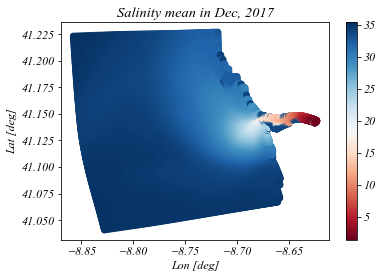

In [5]:
# plot the time average
plt.scatter(lon, lat, c = sal, cmap = 'RdBu')
plt.title("Salinity mean in Dec, 2017")
plt.xlabel("Lon [deg]")
plt.ylabel("Lat [deg]")
plt.colorbar()
plt.show()

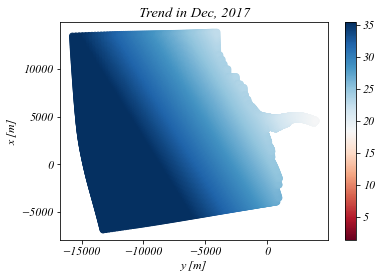

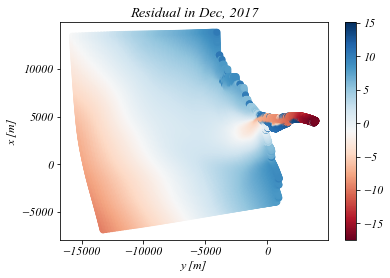

In [6]:
# plot the trend and residual
mu = X @ beta
plt.scatter(y, x, c = mu, cmap = "RdBu", vmin = np.amin(sal), vmax = np.amax(sal))
plt.title("Trend in Dec, 2017")
plt.xlabel("y [m]")
plt.ylabel("x [m]")
plt.colorbar()
plt.show()
residual = sal - mu
plt.scatter(y, x, c = residual, cmap = "RdBu")
plt.title("Residual in Dec, 2017")
plt.xlabel("y [m]")
plt.ylabel("x [m]")
plt.colorbar()
plt.show()

/usr/local/lib/python3.9/site-packages/scikit_gstat-0.5.4-py3.9.egg/skgstat/plotting/variogram_plot.py:96: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   22856.52
Sill:              20.19
Nugget:            22.97
        


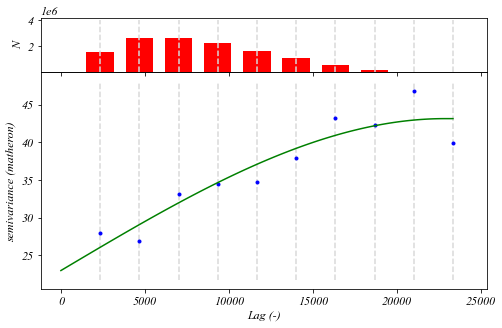

In [8]:
# compute the variogram
from skgstat import Variogram
ind = np.random.randint(0, x.shape[0] - 1, size = 5000) # take out only 5000 random locations, otherwise it takes too long to run
V_v = Variogram(coordinates = np.hstack((x[ind], y[ind])), values = residual[ind].squeeze(), use_nugget=True)
# V_v.fit_method = 'trf' # moment method
fig = V_v.plot(hist = True)
print(V_v)

In [3]:
import os
os.system("say It is time to work")

0